In [1]:
from typing import List


# open GDB-17 SMILES dataset
with open("GDB17.50000000.smi", "r") as smi_file:
    smiles: List[str] = smi_file.readlines()
smi_file.close()

# let's use the first 25k
smiles = smiles[:25000]

# replace newline characters
for i in range(len(smiles)):
    smiles[i] = smiles[i].replace("\n", "")

print(len(smiles))
print(smiles[0])

25000
BrC1=C2C3C4C3N(CC4C#C)C2=NC(=O)S1


In [2]:
from sklearn.model_selection import train_test_split


# 90% for training, 10% for testing
smiles_train, smiles_test = train_test_split(smiles, test_size=0.1, random_state=42)

print(len(smiles_train), len(smiles_test))

22500 2500


In [3]:
import torch

from smiles_autoencoder.encoding import SmilesEncoder


enc = SmilesEncoder()
enc.fit(smiles_train)

encodings_train = torch.tensor(enc.encode_many(smiles_train), dtype=torch.float32)
encodings_test = torch.tensor(enc.encode_many(smiles_test), dtype=torch.float32)

# shape (n_samples, sequence_len, n_features)
print(encodings_train.shape, encodings_test.shape)

torch.Size([22500, 43, 24]) torch.Size([2500, 43, 24])


In [4]:
import numpy as np
import torch.nn as nn

from smiles_autoencoder.model import LSTMAutoencoder


ae = LSTMAutoencoder(
    encodings_train.shape[2],
    64,
    12,
    1
)

opt = torch.optim.Adam(ae.parameters(), lr=0.001)
crit = nn.L1Loss(reduction="sum")

BATCH_SIZE = 1
EPOCHS = 8

losses = []

for epoch in range(EPOCHS):

    _losses = []

    for idx in range(0, encodings_train.shape[0] - 1, BATCH_SIZE):

        opt.zero_grad()
        _batch = encodings_train[idx: min(idx + BATCH_SIZE, encodings_train.shape[0] - 1)]
        pred = ae(_batch)
        loss = crit(pred, _batch)
        loss.backward()
        opt.step()
        _losses.append(loss.item())

    losses.append(np.mean(_losses))
    print(epoch, losses[-1])

0 11.607131413470015
1 1.9812503546082956
2 1.8219382513035158
3 1.4422558219921664
4 0.8457013083114121
5 0.3247736788992405
6 0.27748211878787954
7 0.26657148704308287


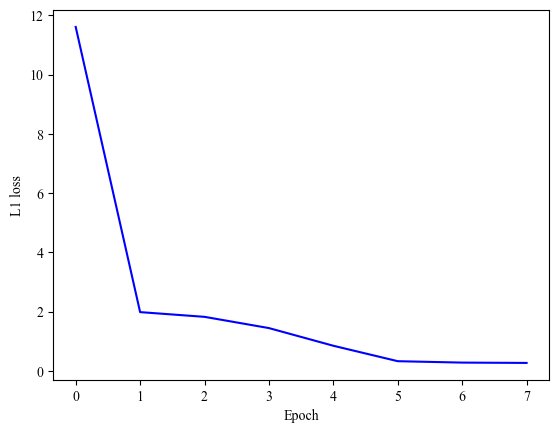

In [5]:
from matplotlib import pyplot as plt


plt.clf()
plt.rcParams["font.family"] = "Times New Roman"
plt.plot([i for i in range(len(losses))], losses, color="blue")
plt.xlabel("Epoch")
plt.ylabel("L1 loss")
plt.show()

In [6]:
n_true = 0
n_false = 0

for idx, sample in enumerate(encodings_train):

    pred = ae(sample)
    _smi = enc.decode(torch.round(pred).detach().numpy().astype(int))
    if _smi == smiles_train[idx]:
        n_true += 1
    else:
        n_false += 1

print(n_true, n_false)
print(n_true / (n_true + n_false))

21761 739
0.9671555555555555


In [7]:
n_true = 0
n_false = 0

for idx, sample in enumerate(encodings_test):

    pred = ae(sample)
    _smi = enc.decode(torch.round(pred).detach().numpy().astype(int))
    if _smi == smiles_test[idx]:
        n_true += 1
    else:
        n_false += 1

print(n_true, n_false)
print(n_true / (n_true + n_false))

2424 76
0.9696
